In [294]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load The dataset

In [295]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

from torchvision import datasets, transforms

train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

train_ = train_set.data.numpy()
train_label = train_set.targets.numpy()

test_= test_set.data.numpy()
test_label = test_set.targets.numpy()


### ConvolutionLayer

In [296]:
class ConvolutionLayer:
    """
    Perform Forward and Backward Convolution Operation
    Input : Number of Filter , Shape , Learning Rate
    
    return : Convolved output
    
    """
    def __init__(self, num_filters, shape, lr):
        
        self.num_filters = num_filters
        x,y,z = shape
        self.kernels = np.random.randn(num_filters,x,y,z ) / x*y*z
        self.learning_rate = lr

    def Relu(self,X):
        return np.maximum(X,0)


    def forward_conv(self, input):
        """
        Perform Forward Convolution
        Input : Input Image of size 28 x 28 x 1 
        Return : Convolved Output of size 28 x 28 x 4
        
        """
        
        self.last_input = input
        h, w ,_  = input.shape
        
        input2 = np.pad(input, ((2,2),(2,2),(0,0)) , mode = 'constant')
        output = np.zeros((h, w, self.num_filters))
        
        for i in range(h):
            for j in range(w):
                
                slice = input2[i:i+5,j:j+5]
                output[i, j] = np.sum(slice * self.kernels)
                
        self.conv_out = output
        # Apply Relu Activation
        output = self.Relu(output)
        
        return output

    def relu_prime(self,x):
        return np.array(x >= 0)

    
    def backprop_conv(self, d_L_d_out):
        """
        Perform Backward Convolution
        
        Input : output from the Backward Pooling operations 
        return : convolved backward output
        
        """
        d_L_d_filters = np.zeros(self.kernels.shape)
        d_L_d_gradient = np.zeros(self.last_input.shape)

        h,w,_ = self.last_input.shape 

        input_2 = np.pad(self.last_input,  ((2,2),(2,2),(0,0)), mode = 'constant')
        d_L_d_gradient= np.pad(d_L_d_gradient,  ((2,2),(2,2),(0,0)), mode = 'constant')

        for i in range(h):
            for j in range(w):
                for f in range(self.num_filters):
                    
                    slice = input_2[i:i+5,j:j+5]
                    d_L_d_gradient[i:i+5,j:j+5, :] += self.kernels[f,:,:,:] * d_L_d_out[i, j, f]
                    d_L_d_filters[f] += d_L_d_out[i, j, f] * slice

        self.kernels -= self.learning_rate * d_L_d_filters
        d_L_d_gradient = d_L_d_gradient[2:-2,2:-2,:]
        d_L_d_gradient = self.relu_prime(d_L_d_gradient)
        
        return d_L_d_gradient

### Max Pooling Layer

In [297]:
class Max_Pooling:
    """
    Perform Pooling operations with 2 Pooling size and 1 stride
    """
    
    def forward_pool(self, input):
        """
        Forward pooling operations
        input : Input from the Convolution Layer
        return : Pooling output 
        """

        self.last_input = input

        h, w, num_filters = input.shape
        new_h = h // 2
        new_w = w // 2
        output = np.zeros((new_h, new_w, num_filters))    


        for i in range(new_h):
            for j in range(new_w):

                slice = self.last_input[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                output[i, j] = np.amax(slice, axis=(0, 1))

        return output

    def backprop_pool(self, d_L_d_out):
        """
        Perform The Backward Propogation
        Input : Output from then Dense layer 
        return : Backward Pooling output
        """
        d_L_d_input = np.zeros(self.last_input.shape)

        h, w, _ = self.last_input.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):

                slice = self.last_input[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                h_new, w_new, f_new = slice.shape
                amax = np.amax(slice, axis=(0, 1))

                for i2 in range(h_new):
                    for j2 in range(w_new):
                        for f2 in range(f_new):
                            if slice[i2, j2, f2] == amax[f2]:
                                d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

### MLP layer

In [313]:
class Dense:
    """
    Perform Forward and Backward propogation on MLP layer
    
    """
    
    def __init__(self, input_len,nodes, output_nodes, update_parameter, lr):
        
        """
        input: Input lenght from flatenning layer, hidden layer nodes, output nodes,
                Update Parameter , learning rate
        """
        input_len = 14*14*4
        
        self.weights1 = np.random.randn(input_len, nodes) / input_len
        self.weights2 = np.random.randn(nodes, output_nodes) / input_len
        
        self.weights = np.random.randn(input_len, output_nodes) / input_len
        self.biases = np.zeros(output_nodes)
        
        self.learning_rate = lr # Learning Rate
        self.update_parameter = update_parameter # Update Parameter
        
        
    def softmax(self, Z):
        """
        Perform Softmax Operation
        """
        out = np.exp(Z) / sum(np.exp(Z))
        return out

    def forward_mlp(self, input):
        """
        Forward Propogation 
        input : Input Images
        return : softmax activation output
        """
        self.last_input_shape = input.shape

        input = input.flatten()
        self.bottle_neck = input
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals
        
        # output after softmax activation function
        softmax_out = self.softmax(totals)
        
        return softmax_out

    
    def softmax_deriv(self, X,i):
        """
        Perfrom The Derative of softmax layer for backpropogation
        """
        t_exp = np.exp(X)

        # Sum of all e^totals
        S = np.sum(t_exp)

        # Gradients of out[i] against totals
        d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
        d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
        return d_out_d_t
        
    def backprop_mlp(self, d_L_d_out):
        """
        Perform Backpropogation on MLP layer
        input : Output from the forward mlp layer
        return : gradient to pooling layer for backward pooling
        
        """
        
        for i, gradient in enumerate(d_L_d_out):
            
            if gradient != 0:
                
                d_out_d_t = self.softmax_deriv(self.last_totals,i)
                # Gradients of totals against weights/biases/input
                d_t_d_w = self.last_input
                d_t_d_b = 1
                d_t_d_inputs = self.weights


                # Gradients of loss against totals
                d_L_d_t = gradient * d_out_d_t

                # Gradients of loss against weights/biases/input
                d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
                d_L_d_b = d_L_d_t * d_t_d_b
                d_L_d_inputs = d_t_d_inputs @ d_L_d_t

                ######## UPDATE WEIGHT #######
                
                ## USING VANILLA SGD LEARNING RATE = 0.001
                if(self.update_parameter == 'sgd_vanilla'):  
                    self.weights -= self.learning_rate * d_L_d_w
                    self.biases -= self.learning_rate * d_L_d_b

                
                # USING MOMENTUM SGD WITH LEARNING RATE = 0.001, MOMENTUM = 0.9
                elif(self.update_parameter == 'sgd_momentum'):
                    
                    momentum = 0.9
                    self.config = {}
                    self.config.setdefault('learning_rate', self.learning_rate)
                    self.config.setdefault('momentum', momentum)
                    v = self.config.get('velocity', np.zeros_like(self.weights))
                    next_w = None
                    v = self.config['momentum'] * v - self.config['learning_rate'] * d_L_d_w
                    next_w = self.weights + v
                    self.config['velocity'] = v
                    self.weights = next_w
                
                
                # USING RMSPROP SGD LEARNING RATE 0.001, DECAY RATE = 0.9, 
                elif(self.update_parameter == 'sgd_rmsprop'):
                    
                    self.config = {}
                    self.config.setdefault('learning_rate', self.learning_rate)
                    self.config.setdefault('decay_rate', 0.9)
                    self.config.setdefault('epsilon', 0.9)
                    self.config.setdefault('cache', np.zeros_like(self.weights))

                    next_x = None

                    decay_rate = self.config['decay_rate']
                    cache = self.config['cache']

                    cache = decay_rate * cache + (1 - decay_rate) * d_L_d_w ** 2
                    next_x = self.weights - self.config['learning_rate'] * d_L_d_w / (np.sqrt(cache) + self.config['epsilon'])

                    self.config['cache'] = cache
                    self.weights = next_x

                else:
                    print("NO SGD GIVEN")


        return d_L_d_inputs.reshape(self.last_input_shape)

### Fully Connected Layer

In [299]:
class Fully_Connected_Layer:
    """
    hERE WE WILL PERFORM THE FULLY CONNECTED CONVOLUTION LAYER WITH BACKPROPOGATION
    
    """
    
    def __init__(self,epoch, update_parameter, learning_rate ):
        """
        input:
        epoch number
        Update parameter : 'sgd_vanilla', 'sgd_momentum', 'sgd_rmsprop'
        Learning Rate : 0.001
        """
        
        self.epoch = epoch
        self.conv = ConvolutionLayer(4, (5,5,1), 0.001)                  # 28x28x1 -> 28x28x4
        self.maxpool = Max_Pooling() 
        self.conv2 = ConvolutionLayer(4, (5,5,4),0.001)                  # 26x26x8 -> 13x13x8
        self.maxpool2 = Max_Pooling()                  # 26x26x8 -> 13x13x8
        self.Dense = Dense(7*7*4, 49, 10 , update_parameter , learning_rate) # 13x13x8 -> 10

    
    
    def one_hot(self, label):
        """
        ONE - HOT encoder to make an 1x10 array of true label
        input : label
        return : 1x10 array of with the index label as 1 and other 0
        """
        return np.eye(10)[label]

    def forward(self,image, y_true):
        """
        Perform Forward Operation for Convolution , Pooling and Forward MLP
        
        input : Image and its label
        return : activation_map,output convolution , Cross-Entropy Loss, Accuracy 
        
        """
        
        ##### FORWARD OPERATIONS #########
        
        conv_layer_output = self.conv.forward_conv((image / 255) - 0.5)
        pooling_layer_output = self.maxpool.forward_pool(conv_layer_output)
        conv_layer_output_ = self.conv2.forward_conv(pooling_layer_output)
        pooling_layer_output_ = self.maxpool2.forward_pool(conv_layer_output_)
        forward_layer_out = self.Dense.forward_mlp(pooling_layer_output)

        
        ##### ONE-HOT ENCODER #######
        y = self.one_hot(y_true)
        
        
        ##### CROSS ENTROPY LOSS #####
        cross_entropy_loss = -np.log(y[y_true]*forward_layer_out[y_true])
        
        
        #### ACCURACY #######
        # if the index of the highest probability is equal to label then 1 else zero
        accuracy = 1 if np.argmax(forward_layer_out) == y_true else 0
        pooling_layer_output
        
        return forward_layer_out, cross_entropy_loss, accuracy
    
    def backward(self, gradient):
        """
        Perform Backward Operations
        
        Input : Gradient
        return: Output after performing the backward propogation
        """
        gradient = self.Dense.backprop_mlp(gradient)
        gradient_ = self.maxpool2.backprop_pool(gradient)
        gradient_ = self.conv2.backprop_conv(gradient)
        gradient = self.maxpool.backprop_pool(gradient)
        gradient = self.conv.backprop_conv(gradient)

        return gradient
    
    

    def train(self,image, y_true):
        """
        Perform Backpropogation Operation for Dense, pooling ,convolution Layer
        
        Input: Image and Label Pair
        
        Return: activation_map, Loss and accuracy
        
        
        """
        ### GET OUTPUT FROM FORWARD LAYER ###
        forward_layer_out, cross_entropy_loss, accuracy = self.forward(image, y_true)

        gradient = np.zeros(10)
        gradient[y_true] = -1 / forward_layer_out[y_true]
        
        ### GET OUTPUT FROM BACKWARD LAYER ###
        gradient = self.backward(gradient)
        
        return cross_entropy_loss, accuracy



    def FCL(self,train_images, train_labels, test_images, test_labels):
        
        """
        Perform the Training and testing of CNN
        
        Input : Training and Testing images and labels
        return :  Training and Testing Loss 
        
        """
        num_train = len(train_images)
        num_test = len(test_images)

        cross_entropy_losses_train = np.zeros(self.epoch)
        cross_entropy_losses_test = np.zeros(self.epoch)
    
        print('Training the CNN - ')

        for epoch in range(self.epoch):
            
            print(f'Epoch : {epoch + 1 }')
            
            #shuffle the images and label pair
            shuffle_data = np.random.permutation(len(train_images))
            train_images = train_images[shuffle_data]
            train_labels = train_labels[shuffle_data]
            
            ####### TRAIN ######
            mean_loss = []
            cross_entropy_loss = 0
            correct_result = 0
            for i, (image, y_true) in enumerate(zip(train_images, train_labels)):
                
                # MIN - BATCH GRADIENT DESCENT
                if i % 100 == 99:
                    mean_loss.append(cross_entropy_loss/100)
                    cross_entropy_loss = 0
#                    correct_result = 0
                
                loss, accuracy = self.train(image, y_true)
                cross_entropy_loss += loss
                correct_result += accuracy
            
            print(f"Train Loss:{np.mean(mean_loss)}, \t Train Accuracy: {correct_result/num_train}")
            cross_entropy_losses_train[epoch] = np.mean(mean_loss)


            cross_entropy_loss_tst = 0
            correct_result = 0
            mean_test_loss = []
       
            for i,(image, y_true) in enumerate(zip(test_images, test_labels)):
                mean_test = []
                if( i%100 == 99):
                    mean_test_loss.append(cross_entropy_loss_tst/100)
                    cross_entropy_loss_tst = 0
                    
                _, l, accuracy = self.forward(image, y_true)
                cross_entropy_loss_tst += l
                correct_result += accuracy
            
            print(f"Test Loss : {np.mean(mean_test_loss)}, \t Test Accuracy : {correct_result/num_test}")
            cross_entropy_losses_test[epoch] = np.mean(mean_test_loss)
        
        bottleneck = self.Dense.bottle_neck
        accuracy  = correct_result / num_test
        activation_map = self.conv.conv_out
        return bottleneck,accuracy , activation_map,cross_entropy_losses_train, cross_entropy_losses_test

### Reshape  dataset 

In [300]:

train_images = train_[:1000].reshape(-1,28,28,1)
train_labels = train_label[:1000]
test_images = test_[:1000].reshape(-1,28,28,1)
test_labels = test_label[:1000]

### Implement Fully Connected Convolution Layer with BackPropogation

In [301]:

epoch = 5
update_parameter = "sgd_vanilla"
learning_rate = 0.001


Fully_connected = Fully_Connected_Layer(epoch,update_parameter, learning_rate)
bottleneck, accuracy , activation_map , cross_entropy_losses, cross_entropy_losses_test =  Fully_connected.FCL(train_images,
                                                                                        train_labels, test_images, test_labels)

Training the CNN - 
Epoch : 1
Train Loss:1.5346995841517441, 	 Train Accuracy: 0.592
Test Loss : 0.8652346864647045, 	 Test Accuracy : 0.715
Epoch : 2
Train Loss:0.6300493797447674, 	 Train Accuracy: 0.805
Test Loss : 0.8289879552746543, 	 Test Accuracy : 0.728
Epoch : 3
Train Loss:0.5720628889201473, 	 Train Accuracy: 0.816
Test Loss : 0.8905204541573278, 	 Test Accuracy : 0.703
Epoch : 4
Train Loss:0.5816495224700258, 	 Train Accuracy: 0.827
Test Loss : 1.2026249756195888, 	 Test Accuracy : 0.64
Epoch : 5
Train Loss:0.608352916554729, 	 Train Accuracy: 0.81
Test Loss : 1.1404484687480774, 	 Test Accuracy : 0.668


### Momentum. learning rate = 0.001, momentum = 0.9

In [311]:

epoch = 5
update_parameter = "sgd_momentum"
learning_rate = 0.001


Fully_connected = Fully_Connected_Layer(epoch,update_parameter, learning_rate)
bottleneck_, accuracy_ , activation_map_ , cross_entropy_losses_, cross_entropy_losses_test_ =  Fully_connected.FCL(train_images,
                                                                                        train_labels, test_images, test_labels)

Training the CNN - 
Epoch : 1
Train Loss:0.9831074217303548, 	 Train Accuracy: 0.69
Test Loss : 0.7251301261519745, 	 Test Accuracy : 0.77
Epoch : 2
Train Loss:0.5399895418556123, 	 Train Accuracy: 0.84
Test Loss : 1.0213266065314324, 	 Test Accuracy : 0.66
Epoch : 3
Train Loss:0.5220261954828489, 	 Train Accuracy: 0.847
Test Loss : 0.794494494729707, 	 Test Accuracy : 0.768
Epoch : 4
Train Loss:0.4998837457353463, 	 Train Accuracy: 0.855
Test Loss : 0.9318207307337205, 	 Test Accuracy : 0.704
Epoch : 5
Train Loss:0.4796016749171887, 	 Train Accuracy: 0.849
Test Loss : 1.047364617749915, 	 Test Accuracy : 0.708


### RMSProp. learning rate = 0.001, decay rate = 0.9

In [314]:

epoch = 5
update_parameter = "sgd_rmsprop"
learning_rate = 0.001


Fully_connected = Fully_Connected_Layer(epoch,update_parameter, learning_rate)
bottleneck__, accuracy__ , activation_map__ , cross_entropy_losses__, cross_entropy_losses_test__ =  Fully_connected.FCL(train_images,
                                                                                        train_labels, test_images, test_labels)

Training the CNN - 
Epoch : 1
Train Loss:1.1904824096960525, 	 Train Accuracy: 0.602
Test Loss : 0.8617275939389589, 	 Test Accuracy : 0.704
Epoch : 2
Train Loss:0.5596209747605629, 	 Train Accuracy: 0.82
Test Loss : 0.6760839447902652, 	 Test Accuracy : 0.778
Epoch : 3
Train Loss:0.45317992606890123, 	 Train Accuracy: 0.861
Test Loss : 0.620931897027533, 	 Test Accuracy : 0.799
Epoch : 4
Train Loss:0.4068462988492554, 	 Train Accuracy: 0.878
Test Loss : 0.6209048455979419, 	 Test Accuracy : 0.808
Epoch : 5
Train Loss:0.36630853837370625, 	 Train Accuracy: 0.892
Test Loss : 0.6424714575148582, 	 Test Accuracy : 0.8


### Training Losses

In [302]:
print(cross_entropy_losses)

[1.53469958 0.63004938 0.57206289 0.58164952 0.60835292]


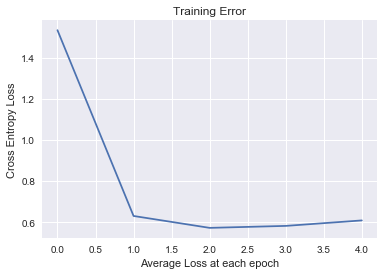

In [303]:
plt.plot(cross_entropy_losses)
plt.title("Training Error")
plt.xlabel('Average Loss at each epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()


### Testing Losses

In [304]:
print(cross_entropy_losses_test)

[0.86523469 0.82898796 0.89052045 1.20262498 1.14044847]


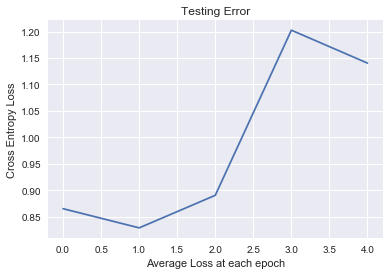

In [305]:
plt.plot(cross_entropy_losses_test)
plt.title("Testing Error")
plt.xlabel('Average Loss at each epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()


### Activation Map

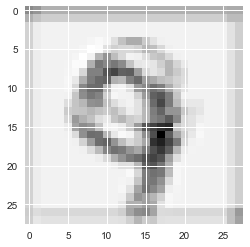

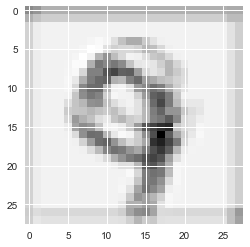

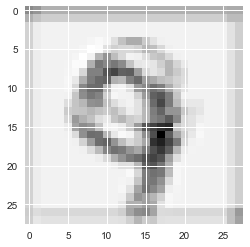

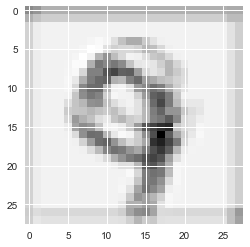

In [306]:
for i in range(4):
    plt.imshow(activation_map[:,:,i])
    plt.show()

### Accuracy

In [307]:
print("Accuracy is ",accuracy)

Accuracy is  0.668


## tSNE

In [308]:
from sklearn.manifold import TSNE

In [309]:
X_embedded = TSNE(n_components=2,init='random').fit_transform(bottleneck.reshape(-1,1))


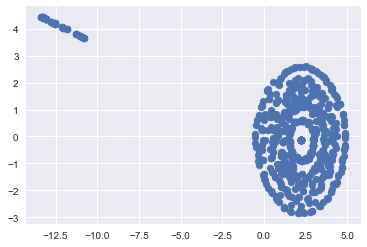

In [310]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])